In [38]:
import pandas as pd
import anndata as ad
import scanpy as sc
import glob
import numpy as np
import QCPipe
import skmisc
import seaborn as sns
import matplotlib.pyplot as plt
import dropkick as dk #Contains dropkick functions

In [ ]:
# concatenate datasets 1,3,5,6

# adata_1 = sc.read_csv('data/4903-YW/4903-YX-1_S01.csv')
# adata_3 = sc.read_csv('data/4903-YW/4903-YX-3_S01.csv')
# adata_5 = sc.read_csv('data/4903-YW/4903-YX-5_S01.csv')
# adata_6 = sc.read_csv('data/4903-YW/4903-YX-6_S01.csv')

# batch_name = ['1', '3', '5', '6']

# adata = adata_1.concatenate(adata_3, adata_5, adata_6, join='outer',fill_value=0,batch_categories=batch_name)

# adata.write_h5ad('data/4903-YW/4903_concat.h5ad',compression='gzip')
# adata = sc.read_h5ad('data/4903-YW/4903_concat.h5ad')

In [64]:
adata = sc.read_h5ad('data/4903-YW/4903_concat.h5ad')

In [45]:
sc.pp.normalize_total(adata)
adata.X = np.arcsinh(adata.X).copy()
sc.pp.scale(adata)
sc.pp.pca(adata,random_state=0)
neighborhood_k = np.sqrt(adata.n_obs).astype(int) 
sc.pp.neighbors(adata,n_neighbors=neighborhood_k,use_rep='X_pca',random_state=0)
sc.tl.umap(adata,min_dist=0.25,random_state=0)
sc.tl.leiden(adata,resolution=2,random_state=0)

/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


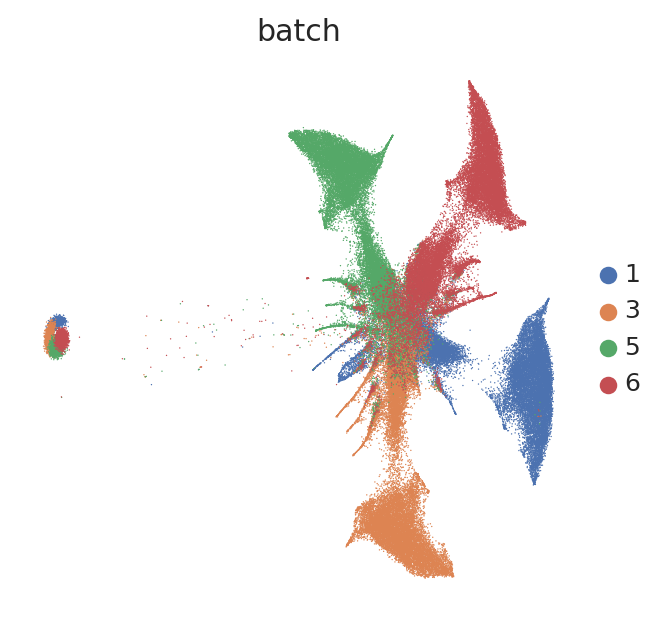

In [46]:
sc.pl.umap(adata,color=['batch'],legend_fontoutline=True,legend_fontsize=10,cmap='viridis',ncols=3,save='batch.png',wspace=0.3,frameon=False)

In [49]:
adata.X[1,:]

array([0., 1., 2., ..., 0., 1., 0.], dtype=float32)

# Apply down sample function

In [50]:
# standardize library sizes by removing nucs with low libs and downsampling the rest
def standardize_libs( adata, tar_lib_sz=1000, seed=123):
    # make sure counts for each nuc are current
    sc.pp.calculate_qc_metrics( adata, percent_top=None, inplace=True)
    # print number of nucs to be removed
    print( "Number of low lib nucs removed per run:")
    low_mk = ( adata.obs['total_counts']<=tar_lib_sz)
    print( adata.obs.loc[low_mk,'batch'].value_counts())# / adata.obs['label'].value_counts())
    
    # remove nucs with low library sizes
    #### comment out line below to keep low UMI count nuclei ####
    sc.pp.filter_cells( adata, min_counts=tar_lib_sz, copy=False)
    
    # downsample nuc total counts over target library size
    sc.pp.downsample_counts( adata, counts_per_cell=tar_lib_sz, copy=False, replace=False, random_state=seed)
    # due to scanpy bug in this version have to reset dtype
    adata.X = adata.X.astype( float)
    return

In [69]:
adata_1 = adata.copy()
adata_100 = adata.copy()
adata_500 = adata.copy()
adata_1000 = adata.copy()
adata_1500 = adata.copy()
adata_2000 = adata.copy()

In [70]:
standardize_libs(adata_1, tar_lib_sz=1, seed=123)
standardize_libs(adata_100, tar_lib_sz=100, seed=123)
standardize_libs(adata_500, tar_lib_sz=500, seed=123)
standardize_libs(adata_1000, tar_lib_sz=1000, seed=123)
standardize_libs(adata_1500, tar_lib_sz=1500, seed=123)
standardize_libs(adata_2000, tar_lib_sz=2000, seed=123)

Number of low lib nucs removed per run:
6    3661
3    3178
5    2588
1    2007
Name: batch, dtype: int64
Number of low lib nucs removed per run:
6    13216
3    12839
5    12468
1    12013
Name: batch, dtype: int64
Number of low lib nucs removed per run:
6    17525
3    16793
5    16609
1    15814
Name: batch, dtype: int64
Number of low lib nucs removed per run:
6    19769
3    19024
5    18922
1    18037
Name: batch, dtype: int64
Number of low lib nucs removed per run:
6    21117
3    20402
5    20292
1    19463
Name: batch, dtype: int64
Number of low lib nucs removed per run:
6    21952
3    21321
5    21229
1    20427
Name: batch, dtype: int64


In [71]:
print(len(adata_1.obs))
print(len(adata_100.obs))
print(len(adata_500.obs))
print(len(adata_1000.obs))
print(len(adata_1500.obs))
print(len(adata_2000.obs))

93654
50323
34074
25055
19534
15873


In [72]:
lib_sizes = [len(adata_1.obs), len(adata_100.obs), len(adata_500.obs), len(adata_1000.obs), len(adata_1500.obs), len(adata_2000.obs)]
lib_labels = [1,100,500,1000,1500,2000]

In [73]:
lib_df = pd.DataFrame(zip(lib_sizes, lib_labels), columns=['Library Size', 'Threshold'])

Text(0.5, 1.0, 'Library Size by Downsample Cutoff')

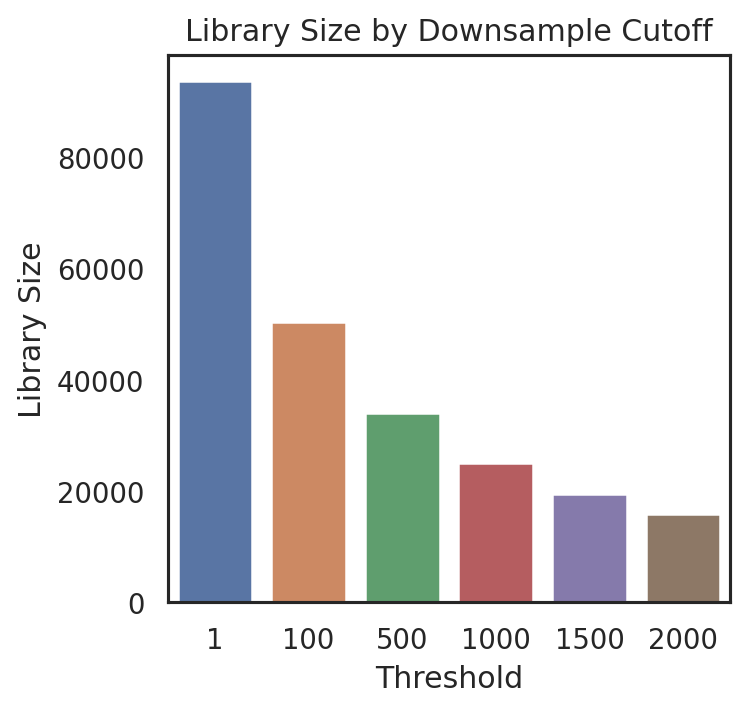

In [74]:
sns.barplot(data=lib_df, x='Threshold', y='Library Size')
plt.title('Library Size by Downsample Cutoff')

In [75]:
sc.pp.highly_variable_genes(adata_1, n_top_genes=100, flavor='cell_ranger')
sc.pp.highly_variable_genes(adata_100, n_top_genes=100, flavor='cell_ranger')
sc.pp.highly_variable_genes(adata_500, n_top_genes=100, flavor='cell_ranger')
sc.pp.highly_variable_genes(adata_1000, n_top_genes=100, flavor='cell_ranger')
sc.pp.highly_variable_genes(adata_1500, n_top_genes=100, flavor='cell_ranger')
sc.pp.highly_variable_genes(adata_2000, n_top_genes=100, flavor='cell_ranger')

hv_idx_1 = adata_1.var['highly_variable']
hv_idx_100 = adata_100.var['highly_variable']
hv_idx_500 = adata_500.var['highly_variable']
hv_idx_1000 = adata_1000.var['highly_variable']
hv_idx_1500 = adata_1500.var['highly_variable']
hv_idx_2000 = adata_2000.var['highly_variable']

hv_1 =  adata_1.var[hv_idx_1 == True]
hv_100 =  adata_100.var[hv_idx_100 == True]
hv_500 =  adata_500.var[hv_idx_500 == True]
hv_1000 =  adata_1000.var[hv_idx_1000 == True]
hv_1500 =  adata_1500.var[hv_idx_1500 == True]
hv_2000 =  adata_2000.var[hv_idx_2000 == True]

hv_1 = hv_1.sort_values('dispersions', ascending=False)
hv_100 = hv_100.sort_values('dispersions', ascending=False)
hv_500 = hv_500.sort_values('dispersions', ascending=False)
hv_1000 = hv_1000.sort_values('dispersions', ascending=False)
hv_1500 = hv_1500.sort_values('dispersions', ascending=False)
hv_2000 = hv_2000.sort_values('dispersions', ascending=False)

In [103]:
sc.pp.highly_variable_genes(adata, n_top_genes=100, flavor='cell_ranger')

hv_idx = adata.var['highly_variable']

hv =  adata.var[hv_idx == True]

hv = hv.sort_values('dispersions', ascending=False)

([], [])

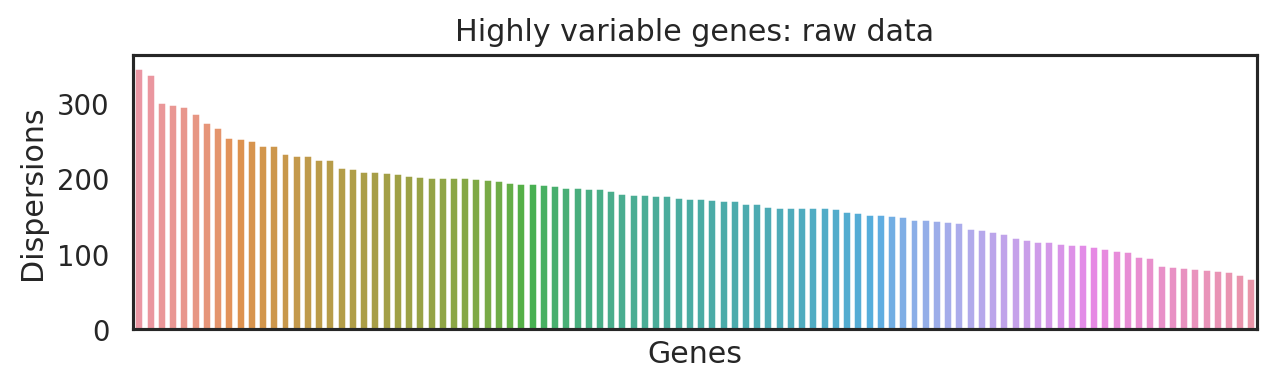

In [105]:
plt.figure(figsize=(8,2))
sns.barplot(data=hv, x=hv.index, y='dispersions')
plt.title('Highly variable genes: raw data')
plt.xlabel('Genes')
plt.ylabel('Dispersions')
plt.xticks([])

([], [])

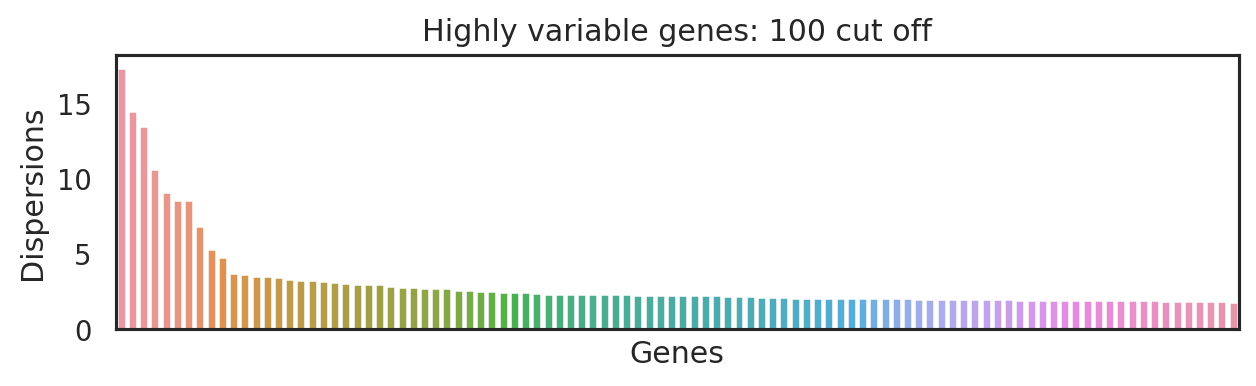

In [95]:
plt.figure(figsize=(8,2))
sns.barplot(data=hv_100, x=hv_100.index, y='dispersions')
plt.title('Highly variable genes: 100 cut off')
plt.xlabel('Genes')
plt.ylabel('Dispersions')
plt.xticks([])

([], [])

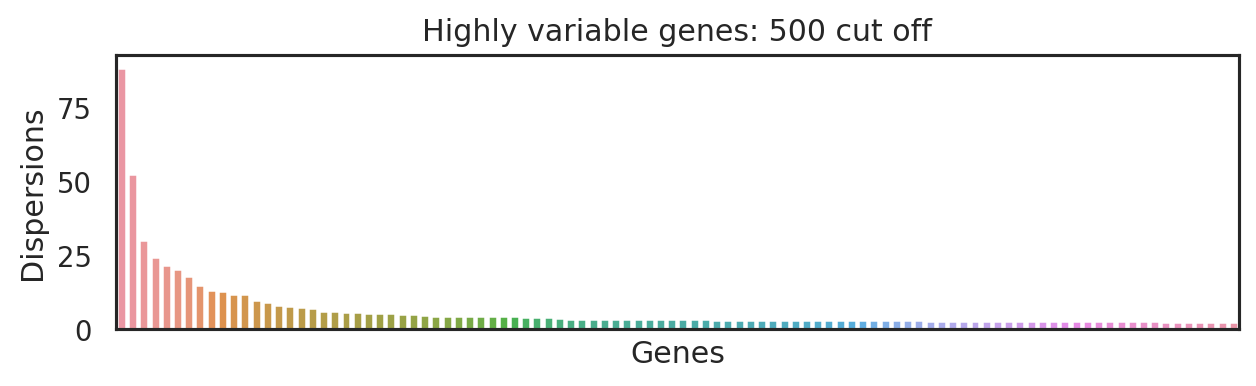

In [96]:
plt.figure(figsize=(8,2))
plt.xticks(rotation=45)
sns.barplot(data=hv_500, x=hv_500.index, y='dispersions')
plt.xlabel('Genes')
plt.ylabel('Dispersions')
plt.title('Highly variable genes: 500 cut off')
plt.xticks([])

([], [])

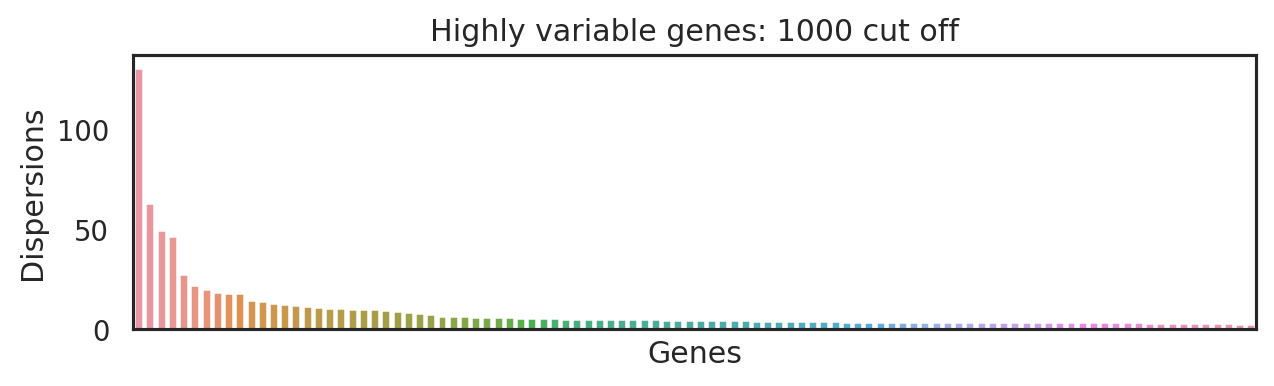

In [106]:
plt.figure(figsize=(8,2))
plt.xticks(rotation=45)
sns.barplot(data=hv_1000, x=hv_1000.index, y='dispersions')
plt.xlabel('Genes')
plt.ylabel('Dispersions')
plt.title('Highly variable genes: 1000 cut off')
plt.xticks([])

([], [])

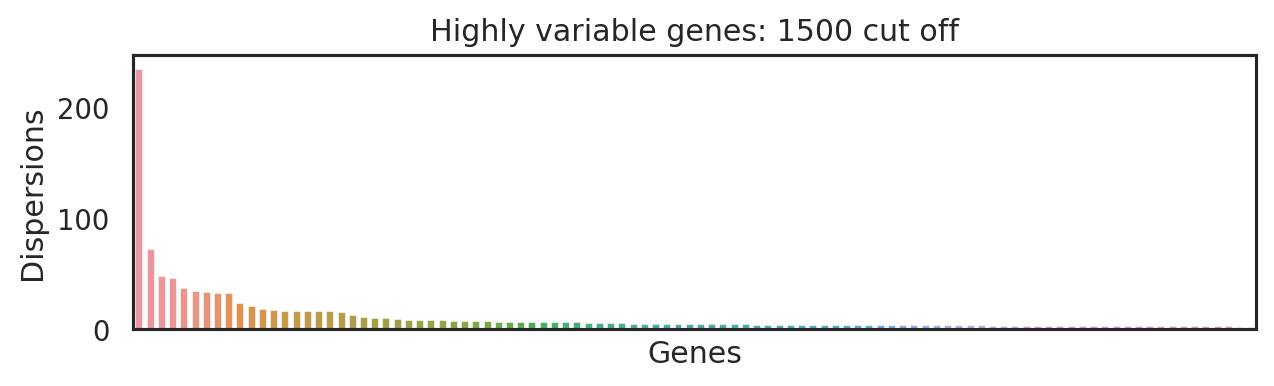

In [107]:
plt.figure(figsize=(8,2))
plt.xticks(rotation=45)
sns.barplot(data=hv_1500, x=hv_1500.index, y='dispersions')
plt.xlabel('Genes')
plt.ylabel('Dispersions')
plt.title('Highly variable genes: 1500 cut off')
plt.xticks([])

([], [])

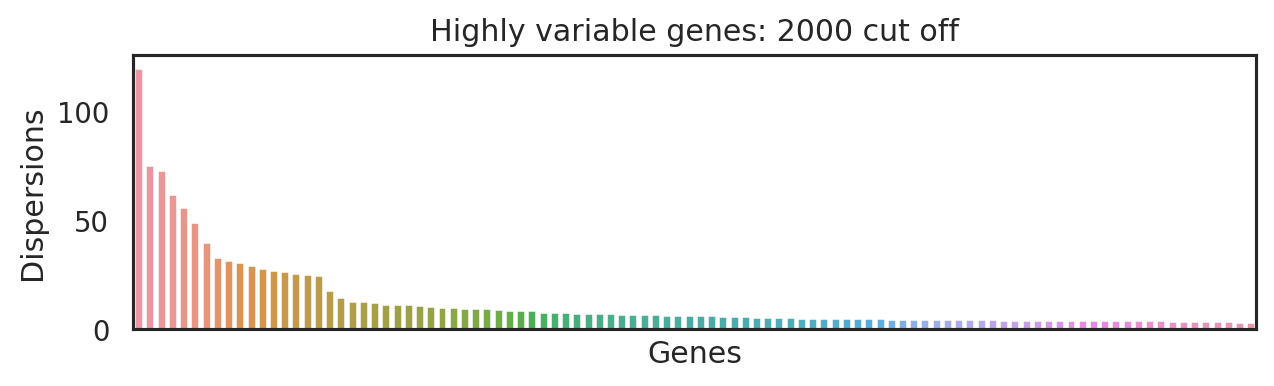

In [108]:
plt.figure(figsize=(8,2))
plt.xticks(rotation=45)
sns.barplot(data=hv_2000, x=hv_2000.index, y='dispersions')
plt.xlabel('Genes')
plt.ylabel('Dispersions')
plt.title('Highly variable genes: 2000 cut off')
plt.xticks([])

# UMAP for each downsample threshold

In [110]:
sc.pp.neighbors(adata_1)
sc.pp.neighbors(adata_100)
sc.pp.neighbors(adata_500)
sc.pp.neighbors(adata_1000)
sc.pp.neighbors(adata_1500)
sc.pp.neighbors(adata_2000)

         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.


In [111]:
sc.tl.umap(adata_1)
sc.tl.umap(adata_100)
sc.tl.umap(adata_500)
sc.tl.umap(adata_1000)
sc.tl.umap(adata_1500)
sc.tl.umap(adata_2000)

/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/jonathan/apps/anaconda3/envs

/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


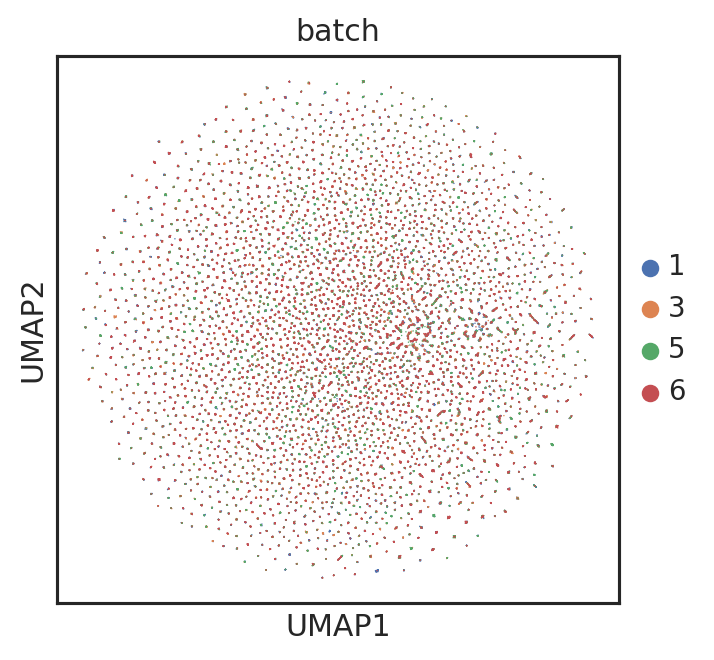

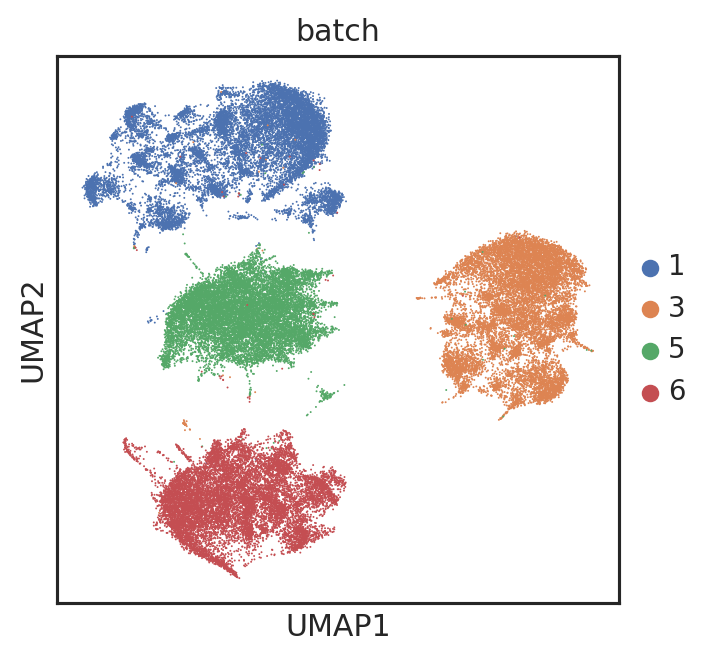

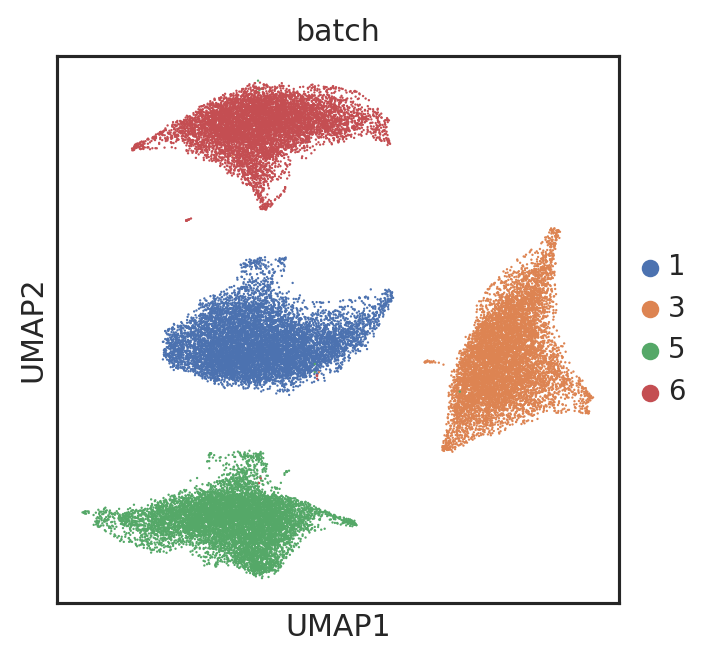

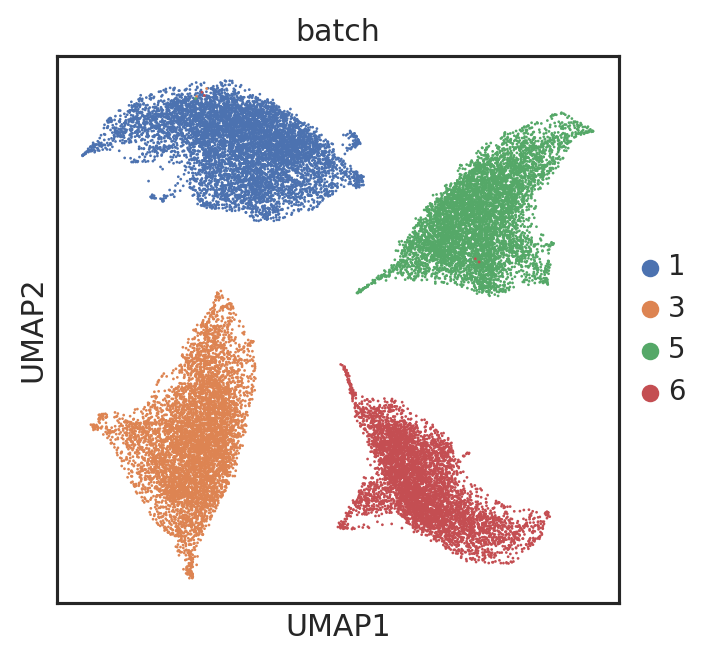

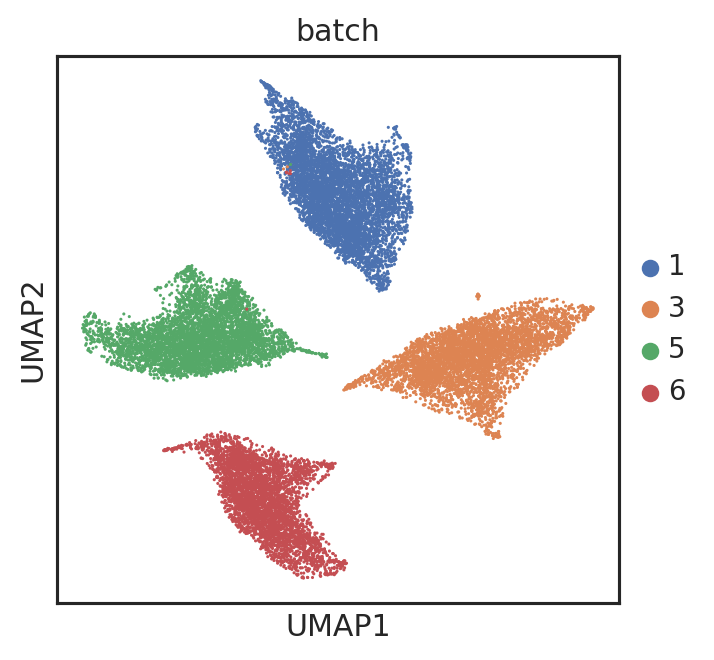

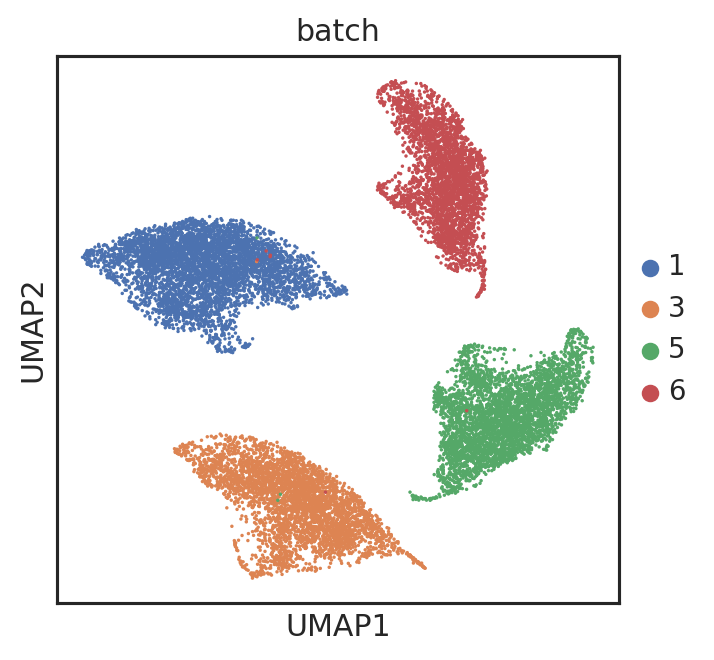

In [112]:
sc.pl.umap(adata_1, color='batch')
sc.pl.umap(adata_100, color='batch')
sc.pl.umap(adata_500, color='batch')
sc.pl.umap(adata_1000, color='batch')
sc.pl.umap(adata_1500, color='batch')
sc.pl.umap(adata_2000, color='batch')

# Let's try batch correction with Harmony next

In [114]:
import harmonypy as hm

In [ ]:
sc.pp.pca(adata,random_state=0)
neighborhood_k = np.sqrt(adata.n_obs).astype(int) 
sc.pp.neighbors(adata,n_neighbors=neighborhood_k,use_rep='X_pca',random_state=0)

meta_data = pd.DataFrame(adata.obs['batch'])
vars_use = ['batch']
data_mat = adata.obsm['X_pca'][:,:5]

ho = hm.run_harmony(data_mat, meta_data, vars_use,max_iter_harmony=50)
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]

adata.obsm['X_pca_harmony'] = res.T.values

sc.pp.neighbors(adata,n_neighbors=neighborhood_k,use_rep='X_pca_harmony',random_state=0)
sc.tl.umap(adata,min_dist=0.25,random_state=0)


2022-12-09 14:39:08,672 - harmonypy - INFO - Iteration 1 of 50
2022-12-09 14:39:40,845 - harmonypy - INFO - Iteration 2 of 50
2022-12-09 14:40:13,125 - harmonypy - INFO - Iteration 3 of 50
2022-12-09 14:40:45,631 - harmonypy - INFO - Converged after 3 iterations


In [ ]:
sc.pl.umap(adata,color=['batch'],legend_fontoutline=True,legend_fontsize=10,palette='tab20',ncols=3,save='batch.png',wspace=0.3,frameon=False)